# Two KDD comparison, 3D, using profiles

We're going to conpare R5 machine (UMMC with GP2 phase space file)  and RX (experimental) machine which has GP3 style source with GP2 collimators. Both used the same L08 cup, R5 was computed with 100,000,000 tracks while RX was computed with 200,000,000 tracks. QA cups were always compiled with 200,000,000 tracks.

In [1]:
import struct
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import RegularGridInterpolator

%matplotlib inline

Selecting reference and evaluation kernels to compare. Reference is R5 machine kernel, while evaluation is RX machine kernel. Same shot position and same collimator to be used, though we don't check it for a time being.

In [2]:
# kernels to compare
kdd_reference  = "D:/XcDoseData/R5/PlanEngineResource/R5/Kdd/R5O3IL08_Y000Z000C025.d3d"
kdd_evaluation = "D:/XcDoseData/RX/PlanEngineResource/RX/Kdd/RXO3IL08_Y000Z000C025.d3d"

# should read it from the kernels
y_shot = 0.0
z_shot = 0.0

## Helper code to load KDDs from binary files

In [3]:
def remake_boundary(f, n: int, sym: bool):
    """
    Given filestream f and number of points n and symmetry flag sym,
    remake the boundary array
    """
    b = np.empty(n + 1, dtype = np.float32)

    for k in range(0, n + 1):
        b[k] = struct.unpack('f', f.read(4))[0]
        
    # here might be code to expand symmetric boundary array

    return b


def readKDD(fname: str):
    """
    Given the file name, read and return data from KDD file
    """
    with open(fname, mode='rb') as f: # b is important -> binary

        # read header, 8*int32, non-relevant information
        h0 = struct.unpack('i', f.read(4))[0]
        h1 = struct.unpack('i', f.read(4))[0]
        h2 = struct.unpack('i', f.read(4))[0]
        h3 = struct.unpack('i', f.read(4))[0]
        h4 = struct.unpack('i', f.read(4))[0]
        h5 = struct.unpack('i', f.read(4))[0]
        h6 = struct.unpack('i', f.read(4))[0]
        h7 = struct.unpack('i', f.read(4))[0]

        # symmetry flags
        xsym = True if struct.unpack('i', f.read(4))[0] != 0 else False
        ysym = True if struct.unpack('i', f.read(4))[0] != 0 else False
        zsym = True if struct.unpack('i', f.read(4))[0] != 0 else False

        # read in nx, ny, and nz, numbers being number of voxels/pixels for X, Y, Z
        nx = struct.unpack('i', f.read(4))[0]
        ny = struct.unpack('i', f.read(4))[0]
        nz = struct.unpack('i', f.read(4))[0]

        # create boundary arrays, read in the boundaries, each one will have size n(x|y|z)+1
        xBoundary = remake_boundary(f, nx, xsym)
        yBoundary = remake_boundary(f, ny, ysym)
        zBoundary = remake_boundary(f, nz, zsym)

        #create dose matrix
        dose = np.empty((nx, ny, nz), dtype = np.float32)

        #read in the dose matrix
        for ix in range(0, nx):
            for iy in range(0, ny):
                for iz in range(0, nz):
                    dose[ix, iy, iz] = struct.unpack('f', f.read(4))[0]

        return (xsym, ysym, zsym, nx, ny, nz, xBoundary, yBoundary, zBoundary, dose)

    return None


def make_grid_from_boundary(b):
    """
    Given boundaries, make grid with points in-between boundaries
    """    
    n = b.shape[0]
    g = np.empty(n - 1, dtype=np.float32)
    
    b_prev = b[0]
    for k in range(0, n-1):
        b_next = b[k+1]
        g[k]   = 0.5*(b_prev + b_next)
        b_prev = b_next
        
    return g

In [5]:
xs_ref, ys_ref, zs_ref, _, _, _, xb_ref, yb_ref, zb_ref, dose_reference  = readKDD(kdd_reference)
xs_evl, ys_evl, zs_evl, _, _, _, xb_evl, yb_evl, zb_evl, dose_evaluation = readKDD(kdd_evaluation)

x_reference = make_grid_from_boundary(xb_ref)
y_reference = make_grid_from_boundary(yb_ref)
z_reference = make_grid_from_boundary(zb_ref)

x_evaluation = make_grid_from_boundary(xb_evl)
y_evaluation = make_grid_from_boundary(yb_evl)
z_evaluation = make_grid_from_boundary(zb_evl)

print(len(x_reference), len(y_reference), len(z_reference))
print(len(x_evaluation), len(y_evaluation), len(z_evaluation))
print(xs_ref, ys_ref, zs_ref)
print(xs_evl, ys_evl, zs_evl)

45 90 101
45 90 101
True False False
True False False


In [6]:
dmax_reference  = np.max(dose_reference)
dmax_evaluation = np.max(dose_evaluation)
ratio = dmax_evaluation / dmax_reference
print("Dmax_ref = {0}, Dmax_eval = {1} (Gy/photon), ratio = {2}".format(dmax_reference, dmax_evaluation,
                                                                        ratio))

Dmax_ref = 1.8742991532121468e-16, Dmax_eval = 1.4052154833962675e-16 (Gy/photon), ratio = 0.7497285008430481


In [7]:
# rescaling to 1, or to KddScalar ?
dose_reference  = dose_reference / dmax_reference
dose_evaluation = dose_evaluation / dmax_evaluation
print("Dmax_ref = {0}, Dmax_eval = {1} (relative dose)".format(np.max(dose_reference), np.max(dose_evaluation)))

Dmax_ref = 1.0, Dmax_eval = 1.0 (relative dose)


## Two plane cuts, reference vs evaluation

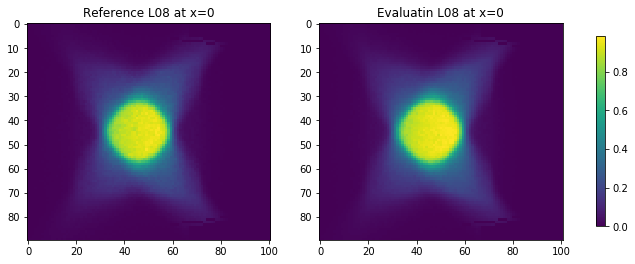

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,7))

im = axes[0].imshow(dose_reference[0,:,:], cmap = "viridis")
axes[0].set_title("Reference L08 at x=0")

clim = im.properties()['clim']
axes[1].imshow(dose_evaluation[0,:,:], clim = clim, cmap = "viridis")
axes[1].set_title("Evaluatin L08 at x=0")

fig.colorbar(im, ax = axes. ravel().tolist(), shrink=0.5)


(0, 2)

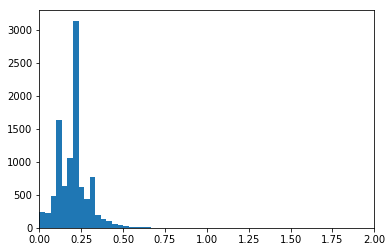

(0, 2)

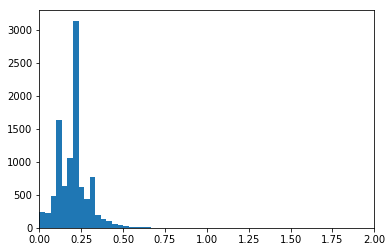

In [12]:
np.sum(valid_gamma <= 1) / len(valid_gamma)

1.0

# Going slice-by-slice in Z direction with step 5, plotting dose and gamma distributions

In [13]:
slice_start = 5
slice_end   = len(z_reference)

C:\Users\kriol\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


Slice = 5
(38, 76) 38 76


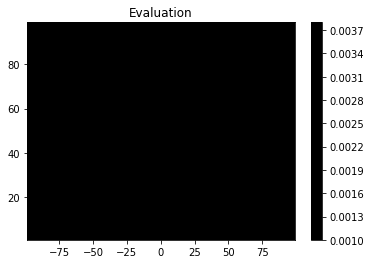

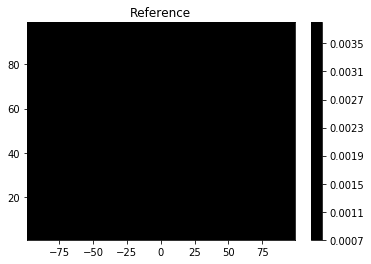

C:\Users\kriol\Anaconda3\lib\site-packages\matplotlib\contour.py:1533: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\Users\kriol\Anaconda3\lib\site-packages\matplotlib\contour.py:1534: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


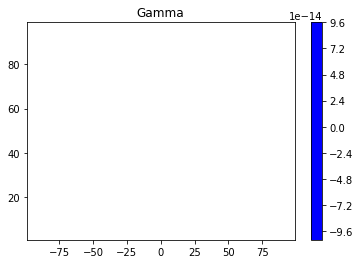



Slice = 15
(38, 76) 38 76


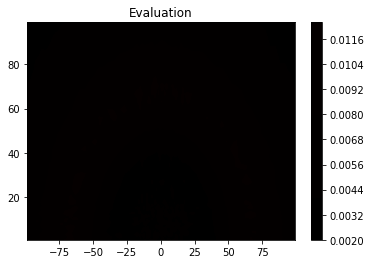

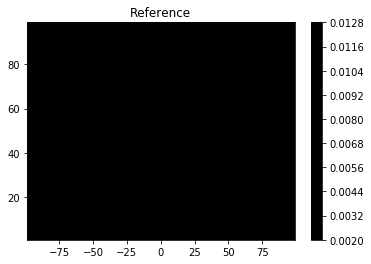

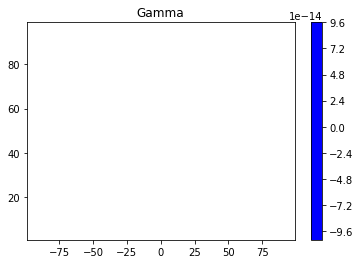



Slice = 25
(38, 76) 38 76


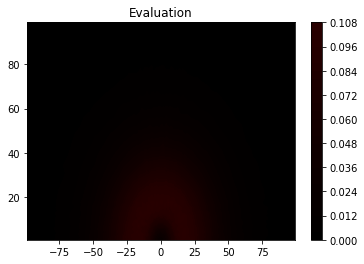

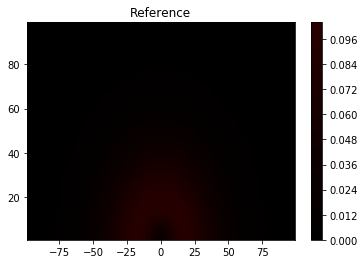

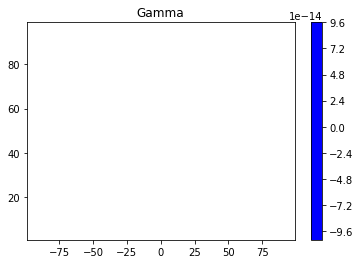



Slice = 35
(38, 76) 38 76


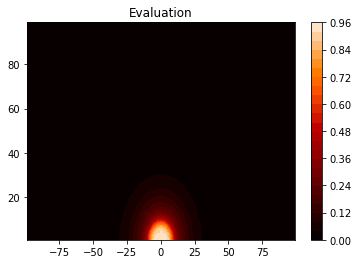

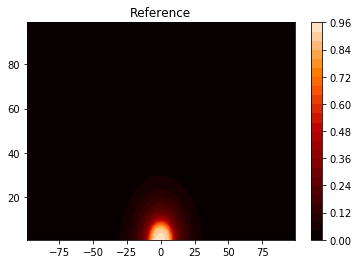

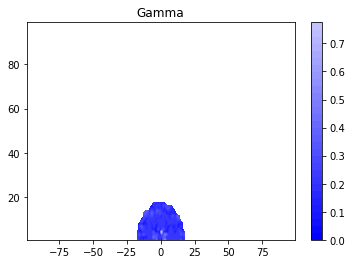



Slice = 45
(38, 76) 38 76


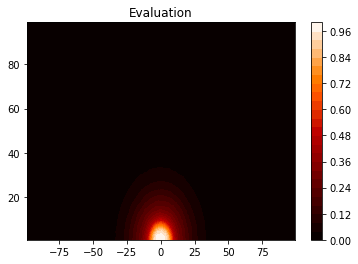

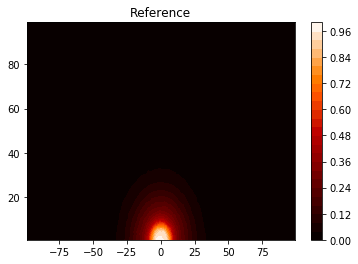

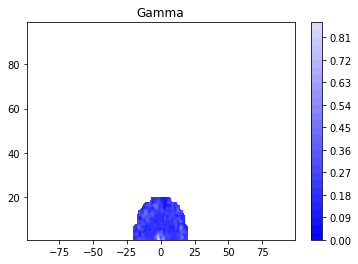



Slice = 55
(38, 76) 38 76


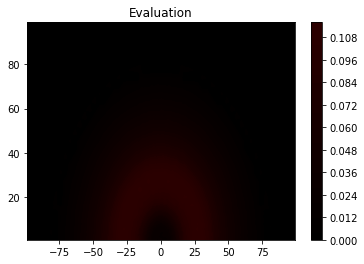

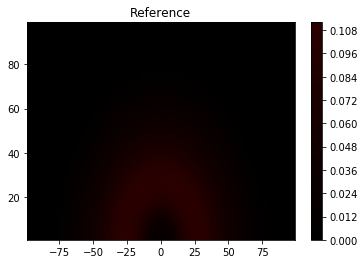

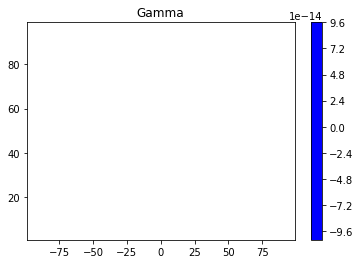



Slice = 65
(38, 76) 38 76


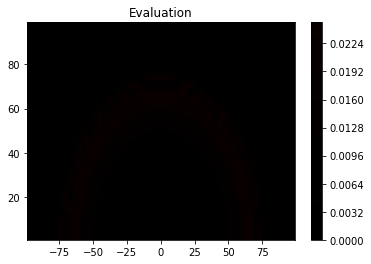

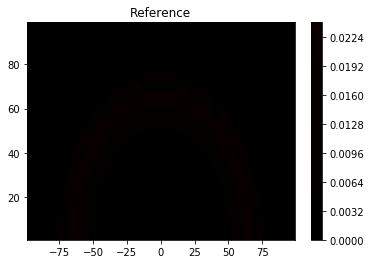

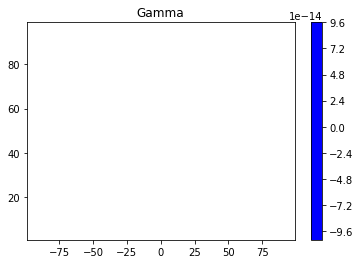



Slice = 75
(38, 76) 38 76


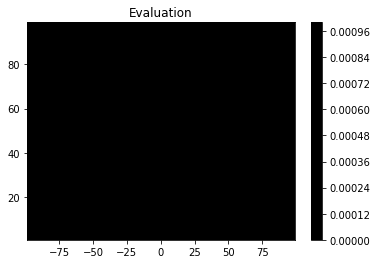

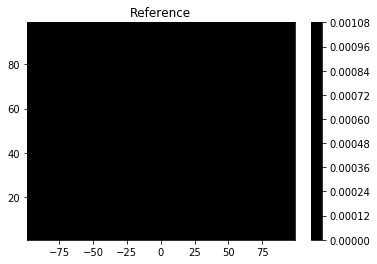

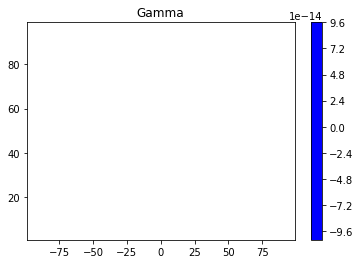



Slice = 85
(38, 76) 38 76


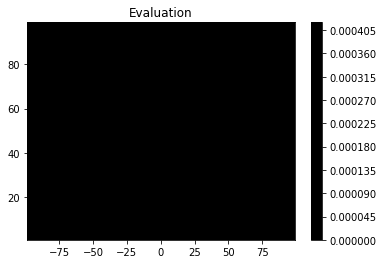

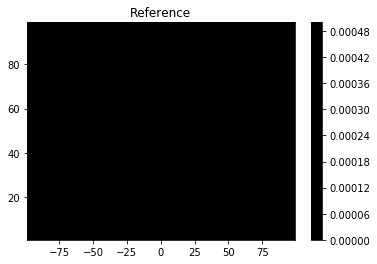

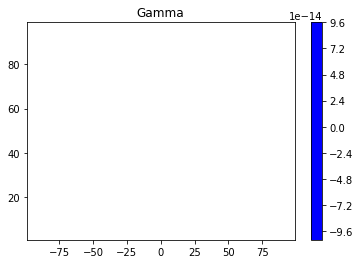

In [14]:
max_ref_dose = np.max(dose_reference)

cut_off_gamma = gamma.copy()
greater_than_2_ref = (cut_off_gamma > 2) & ~np.isnan(cut_off_gamma)
cut_off_gamma[greater_than_2_ref] = 2

for z_i in range(slice_start,slice_end,10):
    print("======================================================================")
    print("Slice = {0}".format(z_i))  
   
    slice_eval = dose_evaluation[:, :, z_i] / max_ref_dose
    print(slice_eval.shape, len(x_evaluation), len(y_evaluation))
    plt.contourf(y_evaluation, x_evaluation, slice_eval, 30, vmin=0, vmax=1.0, cmap=plt.get_cmap('gist_heat'))
    plt.title("Evaluation")
    plt.colorbar()
    plt.show()
    
    slice_ref = dose_reference[:, :, z_i] / max_ref_dose
    plt.contourf(y_reference, x_reference, slice_ref, 30, vmin=0, vmax=1.0, cmap=plt.get_cmap('gist_heat'))
    plt.title("Reference")
    plt.colorbar()
    plt.show()
    
    plt.contourf(y_evaluation, x_evaluation, cut_off_gamma[:, :, z_i], 30, vmin=0, vmax=2, cmap=plt.get_cmap('bwr'))    
    plt.title("Gamma")
    plt.colorbar()
    plt.show()
          
    print("\n")

While at the center of the hotspot there are little differences, we have somewhat visible gamma appearance in the penumbra area